# Introduction
In this notebook I implement a U-Net model with less than 90,000 parameters. The model makes use of inverted residual blocks as the main processing blocks of the models and employs pyramid scene parsing in the 'horizontal' connections of U-Net. The training is not carried out in this notebook, weights from previous training sessions are loaded in. The model is pretrained on the LIVECell dataset [(https://www.nature.com/articles/s41592-021-01249-6)](https://www.nature.com/articles/s41592-021-01249-6) for 8 epochs.

Solarized dark             |  Solarized Ocean
:-------------------------:|:-------------------------:
![alt](__results___8_2.png) | ![__results___10_1.png](__results___10_1.png)


In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras


# Model Generation

In [2]:
###
### Defining the blocks which make up the model
###

def inverted_residual_block(x, expand=64, squeeze=16):
    m = keras.layers.Conv2D(expand, 1, padding='same')(x)
    m = keras.layers.BatchNormalization()(m)
    m = keras.layers.Activation('relu')(m)
    
    m = keras.layers.DepthwiseConv2D(3, padding='same')(m)
    m = keras.layers.BatchNormalization()(m)
    m = keras.layers.Activation('relu')(m)
    
    m = keras.layers.Conv2D(squeeze, 1, padding='same')(m)
    m = keras.layers.BatchNormalization()(m)
    m = keras.layers.Activation('relu')(m)
    
    return keras.layers.add([m, x])

def down_sampling_block(x,filters):
    m = keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)
    # project residual
    # residuals are projected by running a 2D convolution with stride 2 
    # which are then added to the output of the MaxPooling layer as a residual.
    r = keras.layers.Conv2D(filters, 1, strides=2, padding='same')(x)
    return keras.layers.add([m, r])



def up_sampling_block(x, filters):
    m = keras.layers.UpSampling2D(2)(x)
    # project residual
    # residuals are projected by running a 2D convolution with stride 2 
    # which are then added to the output of the MaxPooling layer as a residual.
    r = keras.layers.UpSampling2D(2)(x)
    r = keras.layers.Conv2D(filters, 1, padding='same')(r)
    return keras.layers.add([m, r])


def pyramid_parsing(x, depth=0, img_size=(520, 704),
                    filters=8, f_ratio=8, pyramid=[2,3,6,9]):
    HEIGHT, WIDTH = img_size
    HEIGHT, WIDTH = HEIGHT // 2**depth, WIDTH // 2**depth # the model down samples by 2 for each layer of given 'depth'
        
    y = x
    for bin_val in pyramid:
        
        m = keras.layers.MaxPool2D(pool_size=(HEIGHT//bin_val, WIDTH//bin_val),
                                   padding='same')(x)
        # check if the bin size is larger due to the padding
        m_HEIGHT, m_WIDTH = m.get_shape()[1:3]

            
        m = keras.layers.UpSampling2D(size=(HEIGHT//m_HEIGHT, WIDTH//m_WIDTH))(m)
        # as it stands, with proper use of flooring values and calling the bins, 
        # the layers (if they do not match perfectly) are slightly undersized by several pixels. 
        # resize allows to use nearest neighbor interpolation to extend the edge bins inplace of zero padding. 
        m = keras.layers.Resizing(HEIGHT, WIDTH, interpolation='nearest')(m)
        
        
        # scale down the amount of filters
        m = keras.layers.Conv2D(filters//f_ratio, 1, padding='same')(m)
        m = keras.layers.BatchNormalization()(m)
        m = keras.layers.Activation('relu')(m)
        y = keras.layers.Concatenate()([y, m])
        
    return y

In [3]:
def get_model(img_size, channels, num_classes, filter_list = [8, 16, 32, 64], PSP=False):
    
    
    """
    Creates the U-net model.
    
    Parameters
    ----------
    img_size: tuple
        The dimensions of the input samples (x,y)
    channels: int
        The channels of the input samples
    filter_list: list
        A list of the desired filters to construct the model with. The length of the list defines the depth of the model,
        with the final value being the 'bottom' layer.
    num_classes: int
        The amount of desired output channels.
    PSP: bool
        Defines if the model should use Pyramid Scene Parsing in its layers.
        
    Returns
    -------
    tf.keras Functional API model, samples have shape of (img_size[0], img_size[1], num_classes.)
    
    """
    max_filter = filter_list[-1]
    filter_list = filter_list[:-1]
    
    
    inputs = keras.Input(shape=img_size + (channels,))
    x = inputs # redefine for the loop

    ### Downsampling layers ###
    
    horizontal_connections = [] # collect the outputs of layers to use in the horizontal connection of U-net
    
    depth = 0
    # Used in pyramid parsing
    # for repeating halfing of size
    # 2**depth
    
    for filters in filter_list:
        # point wise convolution to expand filters. 
        x = keras.layers.Conv2D(filters, 1, padding='same')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
        
        x = inverted_residual_block(x, expand=filters*2, squeeze=filters)
        x = inverted_residual_block(x, expand=filters*2, squeeze=filters)

        
        if PSP:
            context_stack = pyramid_parsing(x, depth=depth, img_size=img_size,
                                        filters=filters, f_ratio=filters)
            horizontal_connections.append(context_stack)
            depth += 1
        
        else:
            horizontal_connections.append(x)
        
        x = down_sampling_block(x,filters=filters)
        
        
    ### Bottom layer ### 
    # no horizontal connection
    bottom_filter = max_filter
    x = keras.layers.Conv2D(bottom_filter, 1, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    x = inverted_residual_block(x, expand=bottom_filter*2, squeeze=bottom_filter)
    x = inverted_residual_block(x, expand=bottom_filter*2, squeeze=bottom_filter)
        
    ### Upsampling layers ###

        
    for filters, h_con in zip(filter_list[::-1], horizontal_connections[::-1]):
        # upsample, add the horizontal components
        x = up_sampling_block(x, filters=filters*2)
        x = keras.layers.Concatenate()([x,h_con])
        

        # shrink filters to desired size
        x = keras.layers.Conv2D(filters, 1, padding='same')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)

        
        x = inverted_residual_block(x, expand=filters*2, squeeze=filters)
        x = inverted_residual_block(x, expand=filters*2, squeeze=filters)
        
        
        
     # Add a per-pixel classification layer

    x = keras.layers.Conv2D(num_classes, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    outputs = keras.layers.Activation('sigmoid')(x)
    


    model = keras.Model(inputs, outputs)
    return model

In [4]:
HEIGHT, WIDTH = 520, 704
image_size = (HEIGHT, WIDTH)
model = get_model(image_size, channels=1, num_classes=1, filter_list = [8, 16, 32, 64], PSP=True)
model.load_weights('3_epoch/spyramid_3_epoch') # load the weights from training

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 520, 704, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 520, 704, 8)  16          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 520, 704, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

                                )                                                                 
                                                                                                  
 conv2d_11 (Conv2D)             (None, 260, 352, 32  544         ['activation_11[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_12 (BatchN  (None, 260, 352, 32  128        ['conv2d_11[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_12 (Activation)     (None, 260, 352, 32  0           ['batch_normalization_12[0][0]'] 
                                )                                                                 
          

 batch_normalization_23 (BatchN  (None, 130, 176, 64  256        ['conv2d_21[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_23 (Activation)     (None, 130, 176, 64  0           ['batch_normalization_23[0][0]'] 
                                )                                                                 
                                                                                                  
 depthwise_conv2d_4 (DepthwiseC  (None, 130, 176, 64  640        ['activation_23[0][0]']          
 onv2D)                         )                                                                 
                                                                                                  
 batch_normalization_24 (BatchN  (None, 130, 176, 64  256        ['depthwise_conv2d_4[0][0]']     
 ormalizat

 ormalization)                                                                                    
                                                                                                  
 activation_35 (Activation)     (None, 65, 88, 128)  0           ['batch_normalization_35[0][0]'] 
                                                                                                  
 conv2d_32 (Conv2D)             (None, 65, 88, 64)   8256        ['activation_35[0][0]']          
                                                                                                  
 batch_normalization_36 (BatchN  (None, 65, 88, 64)  256         ['conv2d_32[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_36 (Activation)     (None, 65, 88, 64)   0           ['batch_normalization_36[0][0]'] 
          

 resizing_11 (Resizing)         (None, 130, 176, 32  0           ['up_sampling2d_11[0][0]']       
                                )                                                                 
                                                                                                  
 add_10 (Add)                   (None, 65, 88, 64)   0           ['activation_39[0][0]',          
                                                                  'add_9[0][0]']                  
                                                                                                  
 concatenate_8 (Concatenate)    (None, 130, 176, 33  0           ['add_7[0][0]',                  
                                )                                 'activation_29[0][0]']          
                                                                                                  
 activation_30 (Activation)     (None, 130, 176, 1)  0           ['batch_normalization_30[0][0]'] 
          

 add_12 (Add)                   (None, 130, 176, 32  0           ['activation_43[0][0]',          
                                )                                 'activation_40[0][0]']          
                                                                                                  
 conv2d_39 (Conv2D)             (None, 130, 176, 64  2112        ['add_12[0][0]']                 
                                )                                                                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 130, 176, 64  256        ['conv2d_39[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_44 (Activation)     (None, 130, 176, 64  0           ['batch_normalization_44[0][0]'] 
          

                                                                                                  
 batch_normalization_20 (BatchN  (None, 260, 352, 1)  4          ['conv2d_17[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_18 (Conv2D)             (None, 260, 352, 1)  17          ['resizing_7[0][0]']             
                                                                                                  
 up_sampling2d_15 (UpSampling2D  (None, 260, 352, 32  0          ['add_13[0][0]']                 
 )                              )                                                                 
                                                                                                  
 concatenate_5 (Concatenate)    (None, 260, 352, 18  0           ['concatenate_4[0][0]',          
          

                                )                                                                 
                                                                                                  
 depthwise_conv2d_11 (Depthwise  (None, 260, 352, 32  320        ['activation_51[0][0]']          
 Conv2D)                        )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 2, 2, 8)      0           ['add_1[0][0]']                  
                                                                                                  
 batch_normalization_52 (BatchN  (None, 260, 352, 32  128        ['depthwise_conv2d_11[0][0]']    
 ormalization)                  )                                                                 
                                                                                                  
 up_sampli

 )                              )                                                                 
                                                                                                  
 conv2d_47 (Conv2D)             (None, 520, 704, 16  272         ['up_sampling2d_17[0][0]']       
                                )                                                                 
                                                                                                  
 concatenate_2 (Concatenate)    (None, 520, 704, 11  0           ['concatenate_1[0][0]',          
                                )                                 'activation_9[0][0]']           
                                                                                                  
 activation_10 (Activation)     (None, 520, 704, 1)  0           ['batch_normalization_10[0][0]'] 
                                                                                                  
 add_17 (A

                                                                                                  
 batch_normalization_61 (BatchN  (None, 520, 704, 1)  4          ['conv2d_53[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_61 (Activation)     (None, 520, 704, 1)  0           ['batch_normalization_61[0][0]'] 
                                                                                                  
Total params: 84,489
Trainable params: 80,591
Non-trainable params: 3,898
__________________________________________________________________________________________________


# A Look at the mask performance

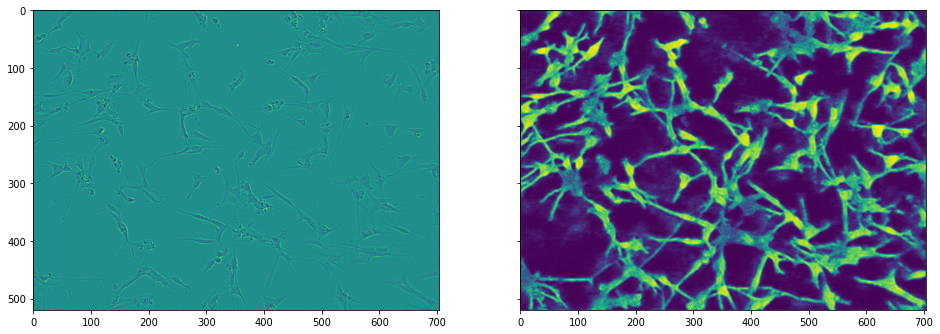

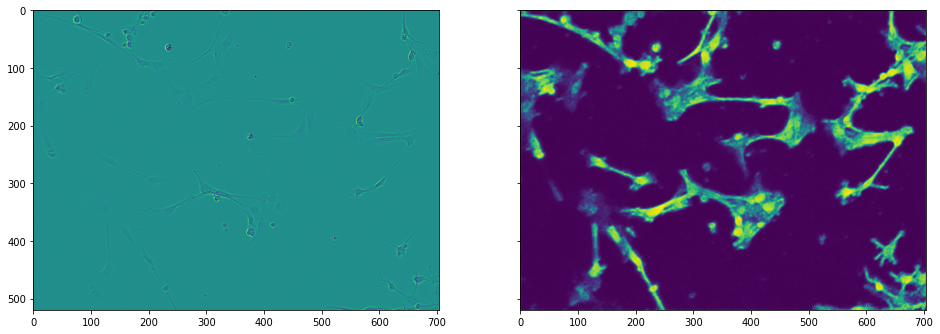

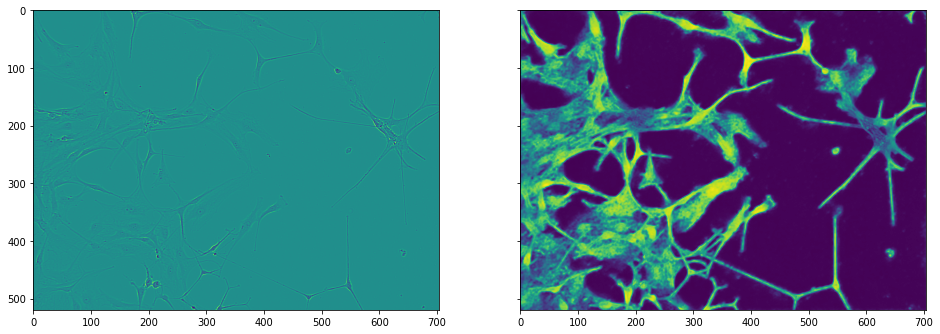

In [5]:
sample_files = ['test_data/7ae19de7bc2a.png',
               'test_data/d48ec7815252.png',
               'test_data/d8bfd1dafdc4.png']


for file_path in sample_files:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,16), sharey=True)

    input_test = plt.imread(str(file_path)).reshape(1, 520, 704, 1)
    input_test = (input_test) - np.mean(input_test) # 
    
    pred = model.predict(input_test) 
    
    ax1.imshow(input_test[0])
    ax2.imshow(pred[0])

As mentioned, the model can actually select out the cells present in the sample. If one wanted to simply select all cells in an image, this is not a bad masker.

# Creating Mask output

In [6]:
import skimage.morphology

############ Submission
def rle_encode(img):
    '''
    img: numpy array. 
        1 - mask, 0 - background
        
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def get_regions(x, THRESHOLD, min_size=25):
    """
    Converts predictions to rle encoded masks.
    
    Parameters
    --------------
    x: numpy array
        Predictions from our model.
    THRESHOLD: float
        The threshold value were we consider a pixel a cell.
    min_size: int
        The minimum size (length) of a mask to be included in our final output.
        
    Returns
    --------------
    res: list
        list of masks encoded into rle encodings. 
    """
    res = []
    regions = skimage.morphology.label(x>THRESHOLD) # select out seperate regions.
    for i in range(1, regions.max() +1):
        rle = rle_encode(regions==i)
        if len(rle) >= min_size: # skip predictions with small area
#             print(len(rle))
            res.append(rle)
        else:
            continue
    return res

In [7]:
test_files = glob('../input/sartorius-cell-instance-segmentation/test/*') # grab all test files

sample_submission = pd.read_csv('../input/sartorius-cell-instance-segmentation/sample_submission.csv')
output_df = pd.DataFrame(data = None, columns = sample_submission.columns)


count = 0 # running count to idx the output df

### Loop over all test files ###
for file_path in test_files:
    tag = file_path.split('/')[-1][:-4] # splits the sample name off from the filepath
    print(tag)
    input_test = plt.imread(str(file_path)).reshape(1, 520, 704, 1) # extra channel in the front so easy input into the model.
    input_test = (input_test) - np.mean(input_test) # zero center the data

    pred = model.predict(input_test)
    regions = get_regions(pred[0], 0.5, min_size=25)
    
    
    for mask in regions:
        output_df.loc[count] = tag, mask
        count+= 1

FileNotFoundError: [Errno 2] No such file or directory: '../input/sartorius-cell-instance-segmentation/sample_submission.csv'

In [ ]:
output_df

In [ ]:
output_df.to_csv('/kaggle/working/submission.csv', index = False)
